In [1]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import datetime
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xlrd

Mounted at /content/drive


# **Data Preprocessing**

***1. This part Play the Responsibility: preprocess the y value and numpy array X of data by Construct several function corresponding to each data type.***

*1.1 Prepare Exporting to csv file*

In [259]:
import csv
def export_to_csv(header_row, data_row, csv_file):
    with open (csv_file, 'w', encoding = 'UTF8', newline='') as f:
        writer = csv.writer(f)

        writer.writerow(header_row)

        writer.writerows(data_row)

path_csv = '/content/drive/MyDrive/Data/Dataset.csv'
header_row = ['Lat', 'Lon', 'Base_PM25', 'Traffic_avg', 'Traffic_norm', 'Traffic_rush', 'Lc1', 'Lc2', 'Lc3', 'Lc4', 'Lc5', 'Lc6', 'Lc7', 'Road_dense', 'Pop_dense', 'altm', 'temp', 'hud', 'wdir', 'wspd', 'vis', 'Expected_PM25']

In [2]:
# read the data expected to the pandas dataframe
df1 = pd.read_csv('/content/drive/My Drive/Data/EPA_merged_2019-2021.csv').drop(columns = ['co', 'no2', 'pm10'])

# This function resolve the problem of unsynchronized data format in df1 'time' landmark
def timeConvert(stringTime):
  if not stringTime.startswith("2021") and not stringTime.startswith("2020"):
    return datetime.datetime.strptime(stringTime, '%d/%m/%Y %H:%M')
  return datetime.datetime.strptime(stringTime, '%Y-%m-%d %H:%M:%S')

df1['time'] = df1['time'].apply(lambda x : timeConvert(x))
df1['Year'] = pd.DatetimeIndex(df1['time']).year
df1['Month'] = pd.DatetimeIndex(df1['time']).month
# Try calculating average of weight groupby Month. But it's necessary to determine that it's not just groupby Month column, it also depend on Year .
df1['Year-Month'] = df1.apply(lambda x: '%s-%s' % (x['Year'], x['Month']), axis = 1)
Month_Series_AVE = df1.groupby(['name', 'Year-Month']).mean()

In [270]:
# Data in full packet without split to train, validation.
Xfull = []

In [5]:
from osgeo import gdal
from osgeo import ogr
import matplotlib.pyplot as plt

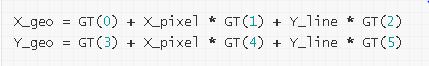

In [6]:
!pip install pyproj
from pyproj import Proj
prj = Proj('+proj=utm +zone=48 +ellps=WGS84 +datum=WGS84 +units=m +no_defs', preserve_units=False, errcheck=True)

     |████████████████████████████████| 6.3 MB 13.7 MB/s 


In [66]:
# This function get the value around point corresponding to particular datatype eg: population, land cover, traffic tile, ...
def getValueAroundPoint(img_data, geotransform, lat, lon, width, nodata, dtype):
    result = np.array((), dtype=np.float32)   
    offset_x = (lat - geotransform[3])/geotransform[5]
    offset_y = (lon - geotransform[0])/geotransform[1]
    evenWidth = ((width%2)==0)
    radius = (width-1)/2.0
    maxOffset = int(np.floor(radius))
    if evenWidth:
        maxOffset = maxOffset + 1
        center_offset_x = np.ceil(offset_x)
        center_offset_y = np.floor(offset_y)
    elif not evenWidth:
        center_offset_x = int(np.floor(offset_x) + 0.5)
        center_offset_y = int(np.floor(offset_y) + 0.5)
    # print(center_offset_x)
    # print(center_offset_y)
    minOffset = int(np.floor(radius) * -1)
    for y in range(minOffset, maxOffset + 1):
        for x in range(minOffset, maxOffset + 1):
            double_x = float(x)
            double_y = float(y)
            real_x = int(center_offset_x - double_x)
            real_y = int(center_offset_y + double_y)
            if evenWidth:
                double_x = double_x - 0.5 
                double_y = double_y - 0.5  
                real_x = int(center_offset_x - (double_x + 0.5))
                real_y = int(center_offset_y + (double_y + 0.5))
            distance = np.sqrt((double_x * double_x) + (double_y * double_y))
            if (0 < real_x < img_data.shape[0]) and (0 < real_y < img_data.shape[1]):
                if (distance <= radius):
                    if (img_data[real_x][real_y] != nodata):
                        if (not np.isnan(img_data[real_x][real_y])):
                            result = np.append(result, img_data[real_x][real_y])
    # print(result.size)
    if (result.size > 0):
        if dtype == 'pop' or dtype == 'traffic' or dtype == 'distribution':
            return np.array([result.mean()], dtype=np.float32)
        elif dtype == 'lc':
            count_1 = np.count_nonzero(result == 1)
            count_2 = np.count_nonzero(result == 2)
            count_3 = np.count_nonzero(result == 3)
            count_4 = np.count_nonzero(result == 4)
            count_5 = np.count_nonzero(result == 5)
            count_6 = np.count_nonzero(result == 6)
            count_7 = np.count_nonzero(result == 7)
            return np.array([count_1, count_2, count_3, count_4, count_5, count_6, count_7], dtype=np.float32)
    else:
        if dtype == 'pop' or dtype == 'traffic' or dtype == 'distribution':
            return np.array([0], dtype=np.float32)
        elif dtype == 'lc':
            return np.array([0, 0, 0, 0, 0, 0, 0], dtype=np.float32)

In [8]:
# Get traffic tile in practical map.
def getTrafficTile(lat, lon, width):
  path1 = "/content/drive/My Drive/Data/average_average_30m.tif"
  path2 = "/content/drive/My Drive/Data/average_normal_30m.tif"
  path3 = "/content/drive/My Drive/Data/average_rush_30m.tif"
  ds1 = gdal.Open(path1)
  ds1_band = ds1.GetRasterBand(1)
  nodataval1 = ds1_band.GetNoDataValue()
  gt1 = ds1.GetGeoTransform()
  ds1_arr = ds1.ReadAsArray().astype(np.float64)

  ds2 = gdal.Open(path2)
  ds2_band = ds2.GetRasterBand(1)
  nodataval2 = ds2_band.GetNoDataValue()
  gt2 = ds2.GetGeoTransform()
  ds2_arr = ds2.ReadAsArray().astype(np.float64)

  ds3 = gdal.Open(path3)
  ds3_band = ds3.GetRasterBand(1)
  nodataval3 = ds3_band.GetNoDataValue()
  gt3 = ds3.GetGeoTransform()
  ds3_arr = ds3.ReadAsArray().astype(np.float64)
  avg = getValueAroundPoint(ds1_arr, gt1, prj(lon, lat)[1], prj(lon, lat)[0], width/gt1[1], nodataval1, 'traffic')
  normal = getValueAroundPoint(ds2_arr, gt2, prj(lon, lat)[1], prj(lon, lat)[0], width/gt2[1], nodataval2, 'traffic')
  rush = getValueAroundPoint(ds3_arr, gt3, prj(lon, lat)[1], prj(lon, lat)[0], width/gt3[1], nodataval3, 'traffic')
  return np.array([avg, normal, rush])

In [9]:
# Get raw data PM25 in practical map.
def getRawPM25(lat, lon, year, month, width):
  path = "/content/drive/My Drive/Data/" + str(year) + "/PM25_" + str(year)

  if month < 10: path = path + '0' + str(month) + '01_hanoi.tif'
  else: path = path + str(month) + '01_hanoi.tif'

  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'distribution')

In [10]:
# Get Population density through year statistical.
def getPopDensity(lat, lon, year, width):
  path = "/content/drive/My Drive/Data/hanoi_pd_" + str(year) + "_30m_Unadj.tif"
  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'pop')

In [11]:
# Get Land Cover in Common
def getLandCover(lat, lon, width):
  path = "/content/drive/My Drive/Data/lc_2017.tif"
  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'lc')

In [12]:
# Get road density statistical
def getRoadDensity(lat, lon, width):
  path = "/content/drive/My Drive/Data/road_density_HN_30m_Clipped.tif"
  ds = gdal.Open(path)
  ds_band = ds.GetRasterBand(1)
  nodataval = ds_band.GetNoDataValue()
  ds_arr = ds.ReadAsArray().astype(np.float64)
  gt = ds.GetGeoTransform()
  return getValueAroundPoint(ds_arr, gt, prj(lon, lat)[1], prj(lon, lat)[0], width/gt[1], nodataval, 'traffic')

In [13]:
# Get VVNB feature
df2 = pd.read_csv('/content/drive/My Drive/Data/VVNB_2019-2021_mean_by_month.csv')
def getVVNB(year, month):
  strquery = "year == '" + str(year) + "' and month == '" + str(year) + "-"
  if month < 10: strquery = strquery + "0" + str(month) + "'"
  else: strquery = strquery + str(month) + "'"
  altm = df2.query(strquery).iloc[0, 2]
  temp = df2.query(strquery).iloc[0, 3]
  hud = df2.query(strquery).iloc[0, 4]
  wdir = df2.query(strquery).iloc[0, 5]
  wspd = df2.query(strquery).iloc[0, 6]
  vis = df2.query(strquery).iloc[0, 7]
  return np.array([altm, temp, hud, wdir, wspd, vis])

***2. This part is beginning extract data to store into numpy array***

In [271]:
# Big Step to store data
# Constantly Width Hyper Parameter: 
width = 900
for i in range(0, len(Month_Series_AVE['lat'])):
  if Month_Series_AVE.iloc[i, 3] == 2021: continue
  X = np.array([[Month_Series_AVE.iloc[i, 1], Month_Series_AVE.iloc[i, 2]]])
  # One datapoint
  # label had been added first
  # Yfull.append(np.array([round(Month_Series_AVE.iloc[i, 0], 4)]))
  lat = round(Month_Series_AVE.iloc[i, 1], 4)
  lon = round(Month_Series_AVE.iloc[i, 2], 4)
  year = Month_Series_AVE.iloc[i, 3]
  month = Month_Series_AVE.iloc[i, 4]
  # inject rawPm25
  X = np.concatenate((X, getRawPM25(lat, lon, year, month, width).reshape(1, -1)), axis = 1)
  # inject traffic tile
  X = np.concatenate((X, getTrafficTile(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject land cover
  X = np.concatenate((X, getLandCover(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject road density
  X = np.concatenate((X, getRoadDensity(lat, lon, width).reshape(1, -1)), axis = 1)
  # inject population density
  X = np.concatenate((X, getPopDensity(lat, lon, year, width).reshape(1, -1)), axis = 1)
  # inject VVNB feature
  X = np.concatenate((X, getVVNB(year, month).reshape(1, -1)), axis = 1)
  # inject expected output
  X = np.concatenate((X, np.array([Month_Series_AVE.iloc[i, 0]]).reshape(1, -1)), axis = 1)
  Xfull.append(X.reshape(22))

In [272]:
# Export to csv
export_to_csv(header_row, Xfull, path_csv)